In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import datetime

#sklearn 
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier

#imblearn to balance training data
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline
from collections import Counter

# XGB
import xgboost as xgb
from xgboost import XGBClassifier
xgb.set_config(verbosity=0) # to supress warnings

# shap
import shap

#joblib to save trained models
import joblib

# Show pipelines as interactive diagram
from sklearn import set_config; set_config(display='diagram')

# Data Science project 2021

**Recidivism prediction** based on ProPublicas COMPAS data

**Content:**
- Intro: ProPublica's COMPAS analysis
- Data preparation
- Feature selection 
- Models for Classification (general recidivism) and regression (COMPAS scores for recidivism)
    - Model iteration 
    - Scoring and comparison of trained models (cross-validated and test scores)
    - Explanation of best model using `SHAP` 
- Fairness discussion

# Intro: ProPublica's COMPAS analysis

- ProPublica obtained records for nearly 12,000 defendants in Broward County, Fla., who were assigned a COMPAS score in 2013-2014. 
- ProPublica then determined which defendants were charged with new crimes in the subsequent two years, and made this data set publicly available.

## Correct ProPublica Two-Year Dataset

In [2]:
# Load df
df = pd.read_csv("../../data-ProPublica/compas-scores-two-years.csv", parse_dates=["compas_screening_date"])

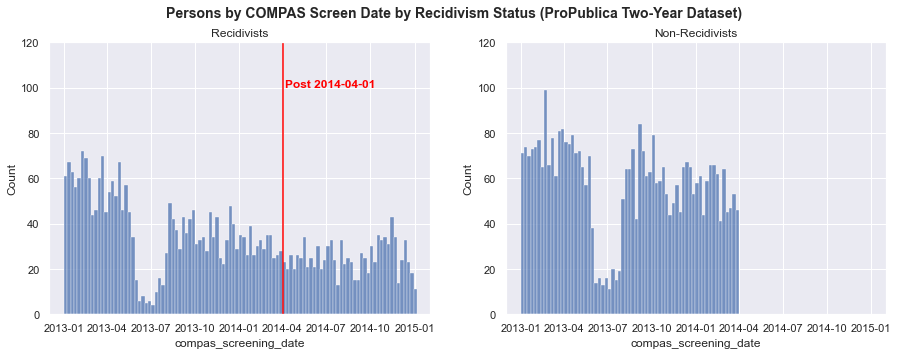

In [3]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Persons by COMPAS Screen Date by Recidivism Status (ProPublica Two-Year Dataset)", fontsize=14, fontweight="bold")
plt.setp(axes, ylim=(0,120), xlim=[datetime.date(2012, 12, 1), datetime.date(2015, 2, 1)])

df_recid = df[df["is_recid"]==1]
df_nonrecid = df[df["is_recid"]==0]

sns.histplot(x="compas_screening_date", data=df_recid, ax=axes[0], binwidth=7)
axes[0].axvline(datetime.date(2014, 4, 1), color="red")
axes[0].text(datetime.date(2014, 4, 7),100,'Post 2014-04-01', color="red", fontweight="bold")
axes[0].set_title("Recidivists")

sns.histplot(x="compas_screening_date", data=df_nonrecid, ax=axes[1], binwidth=7)

axes[1].set_title("Non-Recidivists");

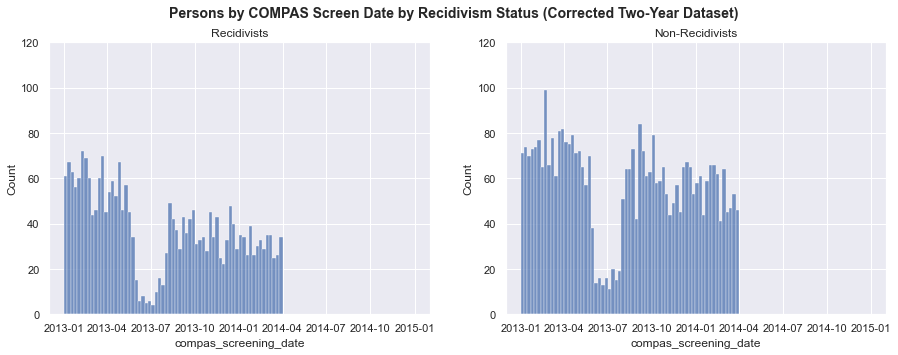

In [4]:
#Implement cutoff after 4/1/2014
df_corrected = df[df["compas_screening_date"]<="2014-04-01"]

#Recreate charts from above to visually confirm results
fig_corr, axes_corr = plt.subplots(1,2, figsize=(15,5))
fig_corr.suptitle("Persons by COMPAS Screen Date by Recidivism Status (Corrected Two-Year Dataset)", fontsize=14, fontweight="bold")
plt.setp(axes_corr, ylim=(0,120), xlim=[datetime.date(2012, 12, 1), datetime.date(2015, 2, 1)])

df_corr_recid = df_corrected[df_corrected["is_recid"]==1]
df_corr_nonrecid = df_corrected[df_corrected["is_recid"]==0]

sns.histplot(x="compas_screening_date", data=df_corr_recid, ax=axes_corr[0], binwidth=7)
            
axes_corr[0].set_title("Recidivists")

sns.histplot(x="compas_screening_date", data=df_corr_nonrecid, ax=axes_corr[1], binwidth=7)

axes_corr[1].set_title("Non-Recidivists");


In [5]:
print("No. of rows in ProPublica's original dataset:", df.shape[0])
print("No. of rows in corrected dataset:", df_corrected.shape[0])

No. of rows in ProPublica's original dataset: 7214
No. of rows in corrected dataset: 6216


## Demographic breakdown

In [6]:
df = df[
        (df["days_b_screening_arrest"]<=30) 
        & (df["days_b_screening_arrest"]>=-30) 
        & (df["is_recid"]!=-1) 
        & (df["c_charge_degree"]!="O") 
        & (df["compas_screening_date"]<="2014-04-01") #for correcting filter error from ProPublica
      ].dropna(subset=['score_text'])

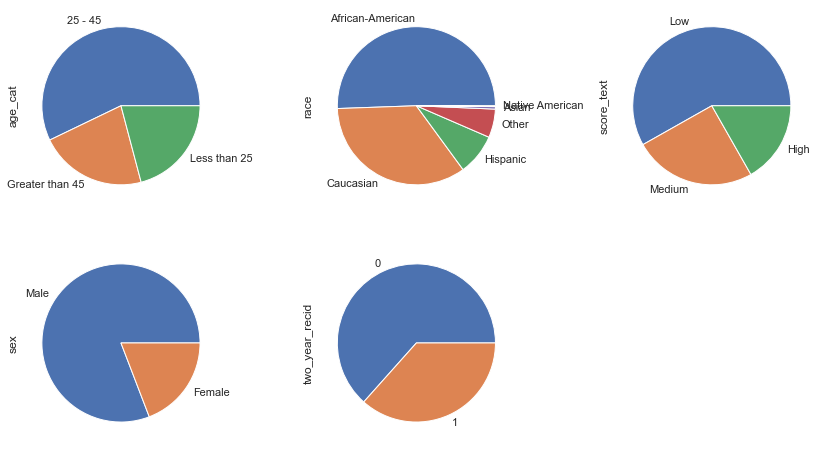

In [7]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(231)
df.age_cat.value_counts().plot.pie();

ax = fig.add_subplot(232)
df.race.value_counts().plot.pie();

ax = fig.add_subplot(233)
df.score_text.value_counts().plot.pie();

ax = fig.add_subplot(234)
df.sex.value_counts().plot.pie();

ax = fig.add_subplot(235)
df["two_year_recid"].value_counts().plot.pie();

In [8]:
# Recreate filter from Washington Post article
df_plot = df[
        (df["days_b_screening_arrest"]<=30) 
        & (df["days_b_screening_arrest"]>=-30) 
        & (df["is_recid"]!=-1) 
        & (df["c_charge_degree"]!="O") 
        & ((df["race"]=="African-American") | (df["race"]=="Caucasian")) 
        & (df["compas_screening_date"]<="2014-04-01") #for correcting filter error from ProPublica
      ].dropna(subset=['score_text'])

## Racial bias in COMPAS

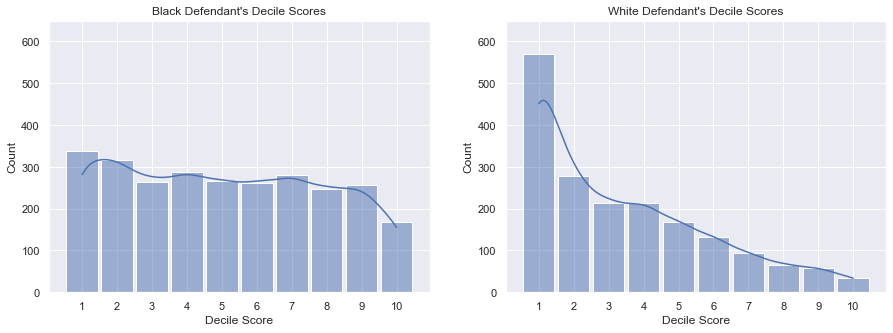

In [17]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.setp(axes, ylim=(0,650), xticks=np.arange(1,11), xlabel="Decile Score")

scores_black = df[df["race"]=="African-American"]["decile_score"]
scores_white = df[df["race"]=="Caucasian"]["decile_score"]

sns.histplot(
    x=scores_black,
    bins=10, 
    ax=axes[0], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[0].set_title("Black Defendant's Decile Scores")

sns.histplot(
    x=scores_white,
    bins=10, 
    ax=axes[1], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[1].set_title("White Defendant's Decile Scores");


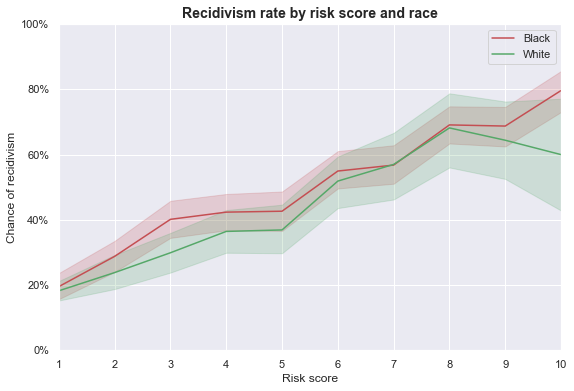

In [18]:
from  matplotlib.ticker import PercentFormatter

fig1, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(x="decile_score",
             y="is_recid",
             hue="race",
             palette=['r', 'g'],
             ax=ax,
             data=df_plot)

ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_title("Recidivism rate by risk score and race", fontsize=14, fontweight="bold")
ax.set(
    xlim=(1,10),
    ylim=(0,1),
    ylabel="Chance of recidivism",
    xlabel="Risk score"
      )
ax.legend(labels=["Black","White"]);

# Data preprocessing & Feature Engineering

## Feature Engineering: `c_charge_degree_detailed`

In [19]:
# Load master lookup table
labeled_charges_master = pd.read_csv("labeled_charges_master.csv", index_col="c_charge_desc")

In [20]:
# Map charge degree to all cases and store in new column "c_charge_degree_detailed"
df_clean = df.merge(labeled_charges_master, how="left", left_on="c_charge_desc", right_index=True)
df_clean.reset_index(drop=True, inplace=True)

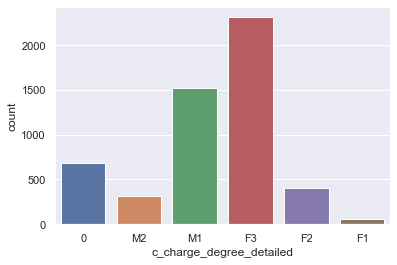

In [22]:
sns.countplot(x="c_charge_degree_detailed", data=df_clean, order=["0","M2", "M1", "F3", "F2", "F1"]);

## Final dataframe for modeling

In [36]:
#Select features for Classification model of general recidivism
# Select age or age_cat, exclude/ include race
columns_clas = ["age", "age_cat", "sex", #"race",  #demographics
               "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
               "c_charge_degree", "c_charge_degree_detailed", #current charges 
               "two_year_recid"] #truth

df_clas = df_clean[columns_clas].copy()

display(df_clas.head(5))

X = df_clas.drop(columns="two_year_recid")
y = df_clas["two_year_recid"]

,age,age_cat,sex,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_degree_detailed,two_year_recid
0,69,Greater than 45,Male,0,0,0,0,F,F3,0
1,34,25 - 45,Male,0,0,0,0,F,F3,1
2,24,Less than 25,Male,0,0,1,4,F,F3,1
3,44,25 - 45,Male,0,0,0,0,M,M1,0
4,41,25 - 45,Male,0,0,0,14,F,F3,1


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

## Create preprocessing pipeline

- `preproc_numerical` to impute and scale features
- `preproc_ordinal` to ordinaly encode `
- `preproc_nominal` to one hot encode the other ones (only relevant when race would be a feature)

In [38]:
feat_ordinal_dict = {
    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
    #"sex": ["Male","Female"],
    "c_charge_degree": ["M", "F"],
    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"]
    }

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal = make_pipeline(
    encoder_ordinal,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal

# Define numerical feature once-for-all
#from sklearn.compose import make_column_selector
#feat_numerical = make_column_selector(dtype_include='number')

feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)
#feat_numerical = sorted(df_clas.select_dtypes(include=["int64", "float64"]).columns)


preproc_numerical = make_pipeline(
    SimpleImputer(),
#    StandardScaler(),
    MinMaxScaler()
)

# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X_train.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary")
)

In [39]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal), 
    remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['M',
                                                                              'F'],
                                                                             ['0',
                                                                              'M2'...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['sex'])])

In [40]:
#Test preproc pipeline
preproc.fit(X_train)

column_nam = feat_numerical + feat_ordinal +list(preproc.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal))

test = pd.DataFrame(preproc.transform(X_train), columns=column_nam)

test.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,c_charge_degree_detailed,sex_Male
0,0.207792,0.0,0.0,0.0,0.324324,0.5,1.0,0.6,0.0
1,0.142857,0.0,0.0,0.0,0.027027,0.5,0.0,0.4,1.0
2,0.194805,0.0,0.0,0.0,0.135135,0.5,1.0,0.6,1.0


# Feature selection

## Feature correlation

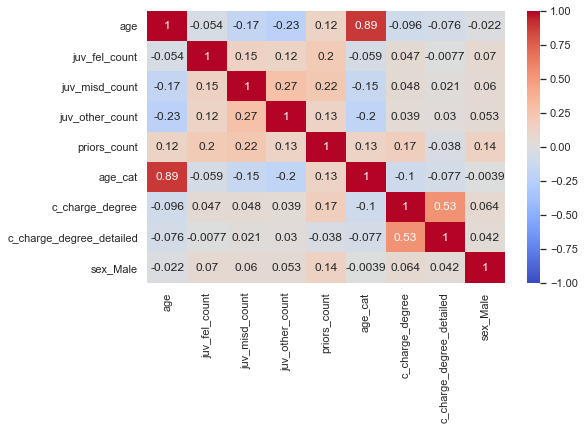

In [47]:
df_enc = pd.DataFrame(preproc.fit_transform(X_train), columns=column_nam)
fig = plt.figure(figsize=(8,5))
sns.heatmap(df_enc.corr(method="spearman"), cmap='coolwarm',vmin=-1, vmax=1, annot=True);

## Feature permutation (MDA)

#### Dataframe without `c_charge_degree` and `age_cat`

In [48]:
# Create new pipeline without features age_cat and c_charge_degree
feat_ordinal_dict_s = {
#    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
#    "c_charge_degree": ["M", "F"],
    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"],
#    "sex": ["Male","Female"]
    }

feat_ordinal_s = sorted(feat_ordinal_dict_s.keys()) # sort alphabetically
feat_ordinal_values_sorted_s = [feat_ordinal_dict_s[i] for i in feat_ordinal_s]

encoder_ordinal_s = OrdinalEncoder(
    categories=feat_ordinal_values_sorted_s,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal_s = make_pipeline(
    encoder_ordinal_s,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal_s;

preproc_s = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal_s, feat_ordinal_s),
    (preproc_nominal, feat_nominal),
    remainder="drop")

pipe_forest_s = make_pipeline(preproc_s, RandomForestClassifier())
pipe_forest_s.fit(X_train, y_train);

column_nam_sub = feat_numerical + feat_ordinal_s +list(preproc.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal))

X_train_sub_trans = pd.DataFrame(preproc_s.transform(X_train), columns=column_nam_sub)

permutation_score_s1 = permutation_importance(pipe_forest_s, X_train[feat_numerical + feat_ordinal_s+feat_nominal], y_train, n_repeats=10) # Perform Permutation

#### Dataframe without `c_charge_degree_detailed` and `age`

In [53]:
# Create new pipeline without features c_charge_degree_detailed and age
feat_ordinal_dict_s2 = {
    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
    "c_charge_degree": ["M", "F"],
#    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"],
#    "sex": ["Male","Female"]
    }

feat_ordinal_s2 = sorted(feat_ordinal_dict_s2.keys()) # sort alphabetically
feat_ordinal_values_sorted_s2 = [feat_ordinal_dict_s2[i] for i in feat_ordinal_s2]

encoder_ordinal_s2 = OrdinalEncoder(
    categories=feat_ordinal_values_sorted_s2,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal_s2 = make_pipeline(
    encoder_ordinal_s2,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal_s2;

# Define numerical feature once-for-all
feat_numerical_s2 = sorted(X.select_dtypes(include=["int64", "float64"]).columns)
feat_numerical_s2.remove("age") #Remove age from list of numerical features

preproc_numerical_s2 = make_pipeline(
    SimpleImputer(),
#    StandardScaler(),
    MinMaxScaler()
)

preproc_s2 = make_column_transformer(
    (preproc_numerical_s2, feat_numerical_s2),
    (preproc_ordinal_s2, feat_ordinal_s2),
    (preproc_nominal, feat_nominal),
    remainder="drop")

pipe_forest_s2 = make_pipeline(preproc_s2, RandomForestClassifier())
pipe_forest_s2.fit(X_train, y_train);

permutation_score_s2 = permutation_importance(pipe_forest_s2, X_train[feat_numerical_s2 + feat_ordinal_s2 +feat_nominal], y_train, n_repeats=10) # Perform Permutation

---
**Show both MDA plots side by side**

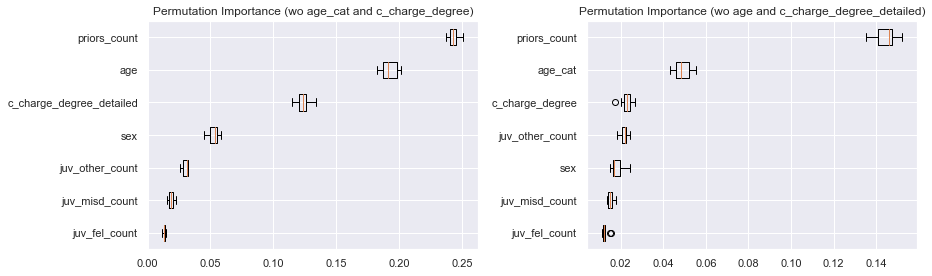

In [57]:
# Both plots side by side
fig = plt.figure(figsize=(13,4))

#Plot MDA train set
plt.subplot(1, 2, 1)
sorted_idx = permutation_score_s1.importances_mean.argsort()
plt.boxplot(
    permutation_score_s1.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical + feat_ordinal_s+feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age_cat and c_charge_degree)")

plt.subplot(1, 2, 2)
sorted_idx = permutation_score_s2.importances_mean.argsort()
plt.boxplot(
    permutation_score_s2.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical_s2 + feat_ordinal_s2 +feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age and c_charge_degree_detailed)")

fig.tight_layout()
plt.show();

- We see more important features in the subset with `age` and `c_charge_degree_detailed`
- Removing `age_cat` and `c_charge_degree` also led to an increase of the overall importance for the other features
- We will now check if including `race` as a feature to the subset might even increase the permutation scores

#### Dataframe without `c_charge_degree` and `age_cat`, but with `race`

In [59]:
columns_clas_race = ["age", "age_cat", "sex", "race",  #demographics
               "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
               "c_charge_degree", "c_charge_degree_detailed", #current charges 
               "two_year_recid"] #truth

df_clas_race = df_clean[columns_clas_race].copy()

X_race = df_clas_race.drop(columns="two_year_recid")
y_race = df_clas_race["two_year_recid"]

X_train_race, X_test_race, y_train_race, y_test_race = train_test_split(X_race,y_race, test_size=0.3)

In [60]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
# only relevant if race is a feature 
feat_nominal_rs = sorted(list(set(X_race.columns.drop(["age_cat", "c_charge_degree"])) - set(feat_numerical) - set(feat_ordinal_s)))

preproc_nominal_rs = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary")
)

In [61]:
preproc_rs = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal_s, feat_ordinal_s),
    (preproc_nominal_rs, feat_nominal_rs),
    remainder="drop")

pipe_forest_rs = imblearn_make_pipeline(preproc_rs, RandomForestClassifier())
pipe_forest_rs.fit(X_train_race, y_train_race)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['0',
                                                                                               'M2',
                                                                                               'M1',
                                                                                               'F3',
                                                                                               'F2',
                                                                                               'F1']],
                                                                                  d...
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['c_charge_degree_detailed']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['race', 'sex'])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [70]:
column_nam_rsub = feat_numerical + feat_ordinal_s +list(preproc_rs.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal_rs))

X_train_rsub_trans = pd.DataFrame(preproc_rs.transform(X_train_race), columns=column_nam_rsub)
X_train_rsub_trans.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male
0,0.359375,0.0,0.0,0.0,0.000000,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.156250,0.0,0.0,0.0,0.162162,0.6,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.359375,0.0,0.0,0.0,0.216216,0.8,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [71]:
permutation_score_rs = permutation_importance(pipe_forest_rs, X_train_race[feat_numerical + feat_ordinal_s+feat_nominal_rs], y_train_race, n_repeats=10) # Perform Permutation

### Comparison subset with and without `race` as a feature

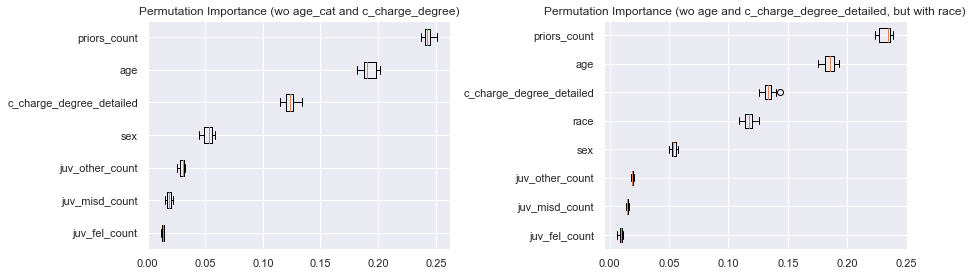

In [72]:
# Both plots side by side
fig = plt.figure(figsize=(13,4))

#Plot MDA train set
plt.subplot(1, 2, 1)
sorted_idx = permutation_score_s1.importances_mean.argsort()
plt.boxplot(
    permutation_score_s1.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical + feat_ordinal_s+feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age_cat and c_charge_degree)")

plt.subplot(1, 2, 2)
sorted_idx = permutation_score_rs.importances_mean.argsort()
plt.boxplot(
    permutation_score_rs.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical + feat_ordinal_s +feat_nominal_rs)[sorted_idx],
)
plt.title("Permutation Importance (wo age and c_charge_degree_detailed, but with race)")

fig.tight_layout()
plt.show();

## Impurity reduction (MDI)

In [73]:
sm = SMOTENC(categorical_features=range(5,9)) # index of categorical features (for order see column_nam)
smt = SMOTETomek(smote=sm)

# Instantiate Random Forest Classifier for MDI 
clf_forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, clf_forest)
pipe_forest.fit(X_train, y_train);

# Create new balancer for subset pipeline
sm_s = SMOTENC(categorical_features=[5,6]) # index of categorical features (for order see column_nam_sub)
smt_s = SMOTETomek(smote=sm_s)

# Instantiate Random Forest Classifier on Subset for MDI 
clf_forest = RandomForestClassifier()
pipe_forest_s = imblearn_make_pipeline(preproc_s, smt_s, clf_forest)
pipe_forest_s.fit(X_train, y_train);

# Create new balancer for subset pipeline with race
sm_rs = SMOTENC(categorical_features=np.arange(5,13)) # index of categorical features (for order see column_nam_rsub)
smt_rs = SMOTETomek(smote=sm_rs)

# Instantiate Random Forest Classifier on Subset for MDI 
clf_forest = RandomForestClassifier()
pipe_forest_rs = imblearn_make_pipeline(preproc_rs, smt_rs, clf_forest)
pipe_forest_rs.fit(X_train_race, y_train_race);

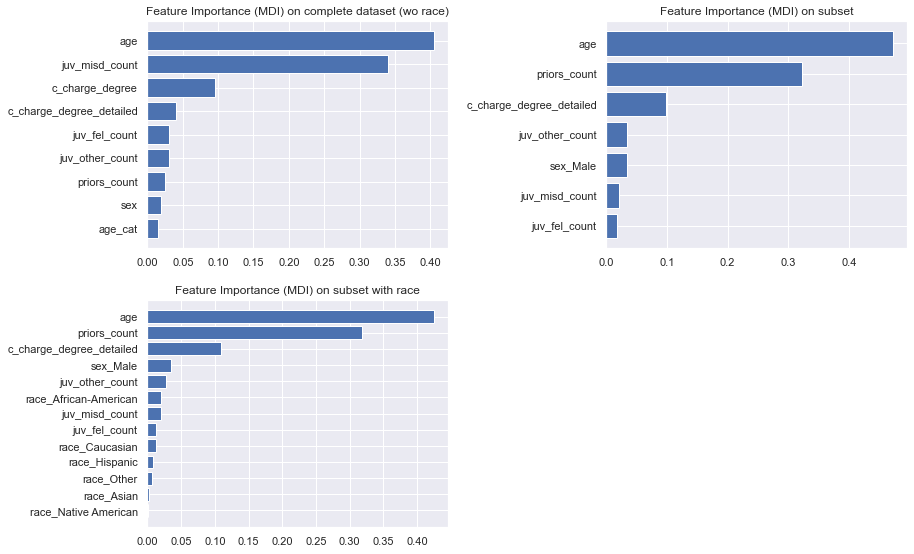

In [77]:
# Both plots side by side
fig = plt.figure(figsize=(13,8))

#Plot MDA train set
plt.subplot(2, 2, 1)
feature_importance = pipe_forest.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI) on complete dataset (wo race)");

plt.subplot(2, 2, 2)
feature_importance_s = pipe_forest_s.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance_s)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance_s[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train_sub_trans.columns)[sorted_idx])
plt.title("Feature Importance (MDI) on subset");

plt.subplot(2, 2, 3)
feature_importance_rs = pipe_forest_rs.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance_rs)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance_rs[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train_rsub_trans.columns)[sorted_idx])
plt.title("Feature Importance (MDI) on subset with race");


plt.tight_layout(pad=1.5)

# Classification - Model iteration

In [80]:
clf_scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'neg_log_loss']

In [82]:
# List for cross validated models (no GridSearch)
cv_results_list=[]
cv_models_list=[]

# List for cross validated models using GridSearch
grid_results_list=[]
grid_models_list=[]

# Dictonary of trained models
dict_models = {}

In [83]:
def save_cv_results(cv_results_list, model_name_list):
    '''Store cv results for all splits and metrics as a list of df'''
    cv_results_df=[]
    
    for i, cv_results in enumerate(cv_results_list):
    
        cv_results = pd.DataFrame(cv_results)

        # Subsetting cv_results (exclude time metrics)
        time_metrics = ['fit_time','score_time'] # fit time metrics
        cv_results_nofit = cv_results.loc[:,~cv_results.columns.isin(time_metrics)].copy()

        #Rename negative log loss and change values to positives (for plotting reasons)
        if "test_neg_log_loss" in cv_results_nofit.columns:
            # Change neg_log_loss to positive number (for plotting) and rename columns
            cv_results_nofit["test_neg_log_loss"] = cv_results_nofit["test_neg_log_loss"].abs()
            cv_results_nofit.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)
        
        cv_results_nofit["model"]=model_name_list[i]
        cv_results_df.append(cv_results_nofit)
        
    return cv_results_df
    # Create df for plot
    #final_nofit_plot = pd.melt(final_nofit, id_vars=['model'], var_name='metrics', value_name='values')

In [84]:
def save_grid_cv_results(grid_model_list, model_name_grid_list, scorings):
    '''Store cv results for each split for each metric of GridSearch of best model as list of df'''
    grid_cv_results_df=[]
    
    for i, grid_model in enumerate(grid_model_list):

        # get index of best model 
        indx = grid_model.cv_results_["params"].index(grid_model.best_params_)

        # Filter grid search cv results for best model
        cv_results_grid = {k:v[indx] for (k,v) in grid_model.cv_results_.items() if k.startswith('split')}

        #scoring metrics
        col_dict = ["test_"+x for x in scorings]

        # Creat dict for plotting with results for each split for each metric of GridSearch for best model
        final_dict = {}
        for col in col_dict:
            for (k,v) in cv_results_grid.items():
                if k.endswith(col):
                    final_dict.setdefault(col, []).append(v)

        df_final = pd.DataFrame(final_dict)
        df_final["model"]=model_name_grid_list[i]

        #Rename negative log loss and change values to positives (for plotting reasons)
        if "test_neg_log_loss" in col_dict:
            # Change neg_log_loss to positive number (for plotting) and rename columns
            df_final["test_neg_log_loss"] = df_final["test_neg_log_loss"].abs()
            df_final.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)
    
        grid_cv_results_df.append(df_final)
        
    
    return grid_cv_results_df

In [86]:
import warnings
warnings.filterwarnings('ignore')

### Baseline model

As a baseline model for the prediction of general recidivism we choose a "Dummy" Classifier which will predict themost frequent class in the target (no_recid)

In [85]:
model_name = "Dummy baseline"
dummy_clf = DummyClassifier(strategy="most_frequent") #Instantiate Dummy Classifier 
baseline = imblearn_make_pipeline(preproc, smt, dummy_clf) #Create pipeline

cv_baseline = cross_validate(baseline, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_baseline)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_baseline['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_baseline['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Dummy baseline: 0.63
10 fold cv ROC AUC score of Dummy baseline: 0.5


`DummyClassifier` has no predict function and thus the precision, recall and f1 metric is set to 0 

### Logistic Regression

#### Untuned Logistic Regression

##### Complete Dataset

In [87]:
model_name = "Vanilla Logistic Regression"
logreg = LogisticRegression()
pipe_log = imblearn_make_pipeline(preproc, smt, logreg) ##Create pipeline

cv_logreg = cross_validate(pipe_log, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_logreg)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_logreg['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_logreg['test_roc_auc'].mean(),2)}")

pipe_log.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_log

10 fold cv accuracy of Vanilla Logistic Regression: 0.67
10 fold cv ROC AUC score of Vanilla Logistic Regression: 0.73


##### Subset

In [88]:
model_name = "Vanilla Logistic Regression_Sub"
logreg = LogisticRegression()
pipe_log_s = imblearn_make_pipeline(preproc_s, smt_s, logreg) ##Create pipeline

cv_logreg_s = cross_validate(pipe_log_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_logreg_s)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_logreg_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_logreg_s['test_roc_auc'].mean(),2)}")

pipe_log_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_log_s

10 fold cv accuracy of Vanilla Logistic Regression_Sub: 0.68
10 fold cv ROC AUC score of Vanilla Logistic Regression_Sub: 0.74


##### Subset with race 

In [89]:
model_name = "Vanilla Logistic Regression_rSub"
logreg = LogisticRegression()
pipe_log_rs = imblearn_make_pipeline(preproc_rs, smt_rs, logreg) ##Create pipeline

cv_logreg_rs = cross_validate(pipe_log_rs, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_logreg_rs)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_logreg_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_logreg_rs['test_roc_auc'].mean(),2)}")

pipe_log_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_log_rs

10 fold cv accuracy of Vanilla Logistic Regression_rSub: 0.67
10 fold cv ROC AUC score of Vanilla Logistic Regression_rSub: 0.73


### Tuned Logistic Regression

#### Complete Dataset

The `l2` solvers are calculated separately to the `elasticnet`, because these solvers do not work with `l1`

In [90]:
model_name = "Tuned Logistic Regression"

param_grid = [# Param grid for Elasticnet
              {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.linspace(1,2,10),
               'logisticregression__l1_ratio': np.arange(0,1.1,0.1)},
              # Param grid for different l2 solvers
              {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.6,2.9,10),
              }
             ]

grid_logreg_tuned = GridSearchCV(pipe_log, param_grid, 
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_logreg_tuned.fit(X_train, y_train);

# Save grid search results as .pkl file 
#joblib.dump(grid_logreg_tuned, 'stored_models/grid_logreg_tuned.pkl')

# Load best model .pkl file 
grid_logreg_tuned = joblib.load('stored_models/grid_logreg_tuned.pkl')

print(grid_logreg_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_logreg_tuned.best_score_, 2)}")

# Store trained model
dict_models[model_name]=grid_logreg_tuned.best_estimator_

grid_models_list.append(model_name)
grid_results_list.append(grid_logreg_tuned)

{'logisticregression__C': 1.8888888888888888, 'logisticregression__l1_ratio': 0.9, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}
10 fold cv ROC AUC score of Tuned Logistic Regression: 0.74


#### Subset

In [91]:
model_name = "Tuned Logistic Regression_Sub"

param_grid = [# Param grid for Elasticnet
              {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.linspace(1,2,10),
               'logisticregression__l1_ratio': np.arange(0,1.1,0.1)},
              # Param grid for different l2 solvers
              {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.6,2.9,10),
              }
             ]

grid_logreg_tuned_s = GridSearchCV(pipe_log_s, param_grid, 
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_logreg_tuned_s.fit(X_train, y_train);

# Save grid search results as .pkl file 
#joblib.dump(grid_logreg_tuned_s, 'stored_models/grid_logreg_tuned_s.pkl')

# Load best model .pkl file 
grid_logreg_tuned_s = joblib.load('stored_models/grid_logreg_tuned_s.pkl')

print(grid_logreg_tuned_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_logreg_tuned_s.best_score_, 2)}")

# Store trained model
dict_models[model_name]=grid_logreg_tuned_s.best_estimator_

grid_models_list.append(model_name)
grid_results_list.append(grid_logreg_tuned_s)

{'logisticregression__C': 2.833333333333333, 'logisticregression__solver': 'sag'}
10 fold cv ROC AUC score of Tuned Logistic Regression_Sub: 0.74


#### Subset with race

In [92]:
model_name = "Tuned Logistic Regression_rSub"

param_grid = [# Param grid for Elasticnet
              {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.arange(2,2.5,0.1),
               'logisticregression__l1_ratio': np.arange(0.6,0.7,0.05),
               'logisticregression__max_iter': [250],
              # Param grid for different l2 solvers
               'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.6,2.9,10),
              }
             ]

grid_logreg_tuned_rs = GridSearchCV(pipe_log_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_logreg_tuned_rs.fit(X_train_race, y_train_race);

# Save grid search results as .pkl file 
#joblib.dump(grid_logreg_tuned_rs, 'stored_models/grid_logreg_tuned_rs.pkl')

# Load best model .pkl file 
grid_logreg_tuned_rs = joblib.load('stored_models/grid_logreg_tuned_rs.pkl')

print(grid_logreg_tuned_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_logreg_tuned_rs.best_score_, 2)}")

# Store trained model
dict_models[model_name]=grid_logreg_tuned_rs.best_estimator_

grid_models_list.append(model_name)
grid_results_list.append(grid_logreg_tuned_rs)

{'logisticregression__C': 2.4000000000000004, 'logisticregression__l1_ratio': 0.6, 'logisticregression__max_iter': 250, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}
10 fold cv ROC AUC score of Tuned Logistic Regression_rSub: 0.73


### Single tree models

Now let's look at Trees. For our project we analyzed following models:
- Vanilla Decision Trees
- Tuned Decision Tree
- Bagged Tuned Decision Tree
- Vanilla Random Forest
- Tuned Random Forest
- Tuned XGB Classifier

#### Single "vanilla" tree model

##### Complete Dataset

In [93]:
model_name = "Vanilla single Tree"
tree = DecisionTreeClassifier(max_depth=3)
pipe_tree = imblearn_make_pipeline(preproc, smt, tree) ##Create pipeline

cv_tree = cross_validate(pipe_tree, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_tree)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_tree['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_tree['test_roc_auc'].mean(),2)}")

pipe_tree.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_tree

10 fold cv accuracy of Vanilla single Tree: 0.69
10 fold cv ROC AUC score of Vanilla single Tree: 0.72


##### Subset

In [94]:
model_name = "Vanilla single Tree_Sub"
tree = DecisionTreeClassifier(max_depth=3)
pipe_tree_s = imblearn_make_pipeline(preproc_s, smt_s, tree) ##Create pipeline

cv_tree_s = cross_validate(pipe_tree_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_tree_s)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_tree_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_tree_s['test_roc_auc'].mean(),2)}")

pipe_tree_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_tree_s

10 fold cv accuracy of Vanilla single Tree_Sub: 0.68
10 fold cv ROC AUC score of Vanilla single Tree_Sub: 0.71


##### Subset with race

In [95]:
model_name = "Vanilla single Tree_rSub"
tree = DecisionTreeClassifier(max_depth=3)
pipe_tree_rs = imblearn_make_pipeline(preproc_rs, smt_s, tree) ##Create pipeline

cv_tree_rs = cross_validate(pipe_tree_rs, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_tree_rs)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_tree_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_tree_rs['test_roc_auc'].mean(),2)}")

pipe_tree_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_tree_rs

10 fold cv accuracy of Vanilla single Tree_rSub: 0.67
10 fold cv ROC AUC score of Vanilla single Tree_rSub: 0.71


#### Single hyperparameter-tuned tree

##### Complete Dataset

In [96]:
model_name = "Tuned single Tree"
tree = DecisionTreeClassifier()
pipe_tree = imblearn_make_pipeline(preproc, smt, tree) ##Create pipeline

#Grid Search
param_grid =  {'decisiontreeclassifier__max_depth': np.arange(2,4),
               'decisiontreeclassifier__min_samples_split': np.arange(2,15,2),
               'decisiontreeclassifier__min_samples_leaf': np.arange(1,100, 20),
               'decisiontreeclassifier__max_features': [None, "sqrt", "log2"]
               }

grid_tree_tuned = GridSearchCV(pipe_tree, param_grid, #n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_tree_tuned.fit(X_train, y_train);

# Save grid search results as .pkl file 
#joblib.dump(grid_tree_tuned, 'stored_models/grid_tree_tuned.pkl')

# Load best model .pkl file 
grid_tree_tuned = joblib.load('stored_models/grid_tree_tuned.pkl')

print(grid_tree_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_tree_tuned.best_score_, 2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_tree_tuned.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_tree_tuned)

{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 81, 'decisiontreeclassifier__min_samples_split': 8}
10 fold cv ROC AUC score of Tuned single Tree: 0.71


##### Subset

In [97]:
model_name = "Tuned single Tree_Sub"
tree = DecisionTreeClassifier()
pipe_tree_s = imblearn_make_pipeline(preproc_s, smt_s, tree) ##Create pipeline

#Grid Search
param_grid =  {'decisiontreeclassifier__max_depth': np.arange(2,4),
               'decisiontreeclassifier__min_samples_split': np.arange(2,15,2),
               'decisiontreeclassifier__min_samples_leaf': np.arange(1,100, 20),
               'decisiontreeclassifier__max_features': [None, "sqrt", "log2"]
               }

grid_tree_tuned_s = GridSearchCV(pipe_tree_s, param_grid, #n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_tree_tuned_s.fit(X_train, y_train);

# Save grid search results as .pkl file 
#joblib.dump(grid_tree_tuned_s, 'stored_models/grid_tree_tuned_s.pkl')

# Load best model .pkl file 
grid_tree_tuned_s = joblib.load('stored_models/grid_tree_tuned_s.pkl')

print(grid_tree_tuned_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_tree_tuned_s.best_score_, 2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_tree_tuned_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_tree_tuned_s)

{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 61, 'decisiontreeclassifier__min_samples_split': 8}
10 fold cv ROC AUC score of Tuned single Tree_Sub: 0.72


##### Subset with race

In [98]:
model_name = "Tuned single Tree_rSub"
tree = DecisionTreeClassifier()
pipe_tree_rs = imblearn_make_pipeline(preproc_rs, smt_s, tree) ##Create pipeline

#Grid Search
param_grid =  {'decisiontreeclassifier__max_depth': np.arange(2,4),
               'decisiontreeclassifier__min_samples_split': np.arange(2,15,2),
               'decisiontreeclassifier__min_samples_leaf': np.arange(1,100, 20),
               'decisiontreeclassifier__max_features': [None, "sqrt", "log2"]
               }

grid_tree_tuned_rs = GridSearchCV(pipe_tree_rs, param_grid, #n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_tree_tuned_rs.fit(X_train_race, y_train_race);

# Save grid search results as .pkl file 
#joblib.dump(grid_tree_tuned_rs, 'stored_models/grid_tree_tuned_rs.pkl')

# Load best model .pkl file 
grid_tree_tuned_rs = joblib.load('stored_models/grid_tree_tuned_rs.pkl')

print(grid_tree_tuned_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_tree_tuned_rs.best_score_, 2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_tree_tuned_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_tree_tuned_rs)

{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 21, 'decisiontreeclassifier__min_samples_split': 6}
10 fold cv ROC AUC score of Tuned single Tree_rSub: 0.72


#### Bagged Tuned Decision Tree

##### Complete Dataset

In [99]:
# Create dict of params for instantiating best Decision Tree (based on GridSearch) to use as base estimator in Bagged Tree
best_params_old = grid_tree_tuned.best_params_
best_params_new = {key[len("decisiontreeclassifier__"):]: value for key, value in best_params_old.items()}

model_name = "Bagged tuned single Tree"
base_estimator=DecisionTreeClassifier(**best_params_new) # Instantiate best model from gridsearch
bagged_tree = BaggingClassifier(base_estimator=DecisionTreeClassifier(**best_params_new), n_estimators=501)
pipe_bagtree = imblearn_make_pipeline(preproc, smt, bagged_tree) ##Create pipeline

#Grid Search
param_grid =  {'baggingclassifier__n_estimators': [320],
               'baggingclassifier__max_samples': [0.5],
               'baggingclassifier__max_features': [0.6],
               'baggingclassifier__oob_score': [True]
               }

grid_bagtree = GridSearchCV(pipe_bagtree, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_bagtree.fit(X_train, y_train);

# Save grid search results as .pkl file 
#joblib.dump(grid_bagtree, 'stored_models/grid_bagtree.pkl')

# Load best model .pkl file 
grid_bagtree = joblib.load('stored_models/grid_bagtree.pkl')

print(grid_bagtree.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_bagtree.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_bagtree.best_estimator_['baggingclassifier'].oob_score_,2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_bagtree.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_bagtree)

{'baggingclassifier__max_features': 0.6, 'baggingclassifier__max_samples': 0.5, 'baggingclassifier__n_estimators': 320, 'baggingclassifier__oob_score': True}
10 fold cv ROC AUC score of Bagged tuned single Tree: 0.74
ROC AUC score on OOB samples: 0.71


##### Subset

In [100]:
# Create dict of params for instantiating best Decision Tree (based on GridSearch) to use as base estimator in Bagged Tree
best_params_old_s = grid_tree_tuned_s.best_params_
best_params_new_s = {key[len("decisiontreeclassifier__"):]: value for key, value in best_params_old_s.items()}

model_name = "Bagged tuned single Tree_Sub"
base_estimator_s=DecisionTreeClassifier(**best_params_new_s) # Instantiate best model from gridsearch
bagged_tree_s = BaggingClassifier(base_estimator=base_estimator_s, n_estimators=501)
pipe_bagtree_s = imblearn_make_pipeline(preproc_s, smt_s, bagged_tree_s) ##Create pipeline

#Grid Search
param_grid =  {'baggingclassifier__n_estimators': [250, 320, 370],
               'baggingclassifier__max_samples': [0.4,0.5,0.6],
               'baggingclassifier__max_features': [0.5,0.6,0.7,1],
               'baggingclassifier__oob_score': [True]
               }

grid_bagtree_s = GridSearchCV(pipe_bagtree_s, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_bagtree_s.fit(X_train, y_train);

# Save grid search results as .pkl file 
#joblib.dump(grid_bagtree_s, 'stored_models/grid_bagtree_s.pkl')

# Load best model .pkl file 
grid_bagtree_s = joblib.load('stored_models/grid_bagtree_s.pkl')

print(grid_bagtree_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_bagtree_s.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_bagtree_s.best_estimator_['baggingclassifier'].oob_score_,2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_bagtree_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_bagtree_s)

{'baggingclassifier__max_features': 0.7, 'baggingclassifier__max_samples': 0.5, 'baggingclassifier__n_estimators': 320, 'baggingclassifier__oob_score': True}
10 fold cv ROC AUC score of Bagged tuned single Tree_Sub: 0.74
ROC AUC score on OOB samples: 0.7


##### Subset with race

In [101]:
# Create dict of params for instantiating best Decision Tree (based on GridSearch) to use as base estimator in Bagged Tree
best_params_old_rs = grid_tree_tuned_rs.best_params_
best_params_new_rs = {key[len("decisiontreeclassifier__"):]: value for key, value in best_params_old_rs.items()}

model_name = "Bagged tuned single Tree_rSub"
base_estimator_rs=DecisionTreeClassifier(**best_params_new_rs) # Instantiate best model from gridsearch
bagged_tree_rs = BaggingClassifier(base_estimator=base_estimator_rs, n_estimators=501)
pipe_bagtree_rs = imblearn_make_pipeline(preproc_rs, smt_s, bagged_tree_rs) ##Create pipeline

#Grid Search
param_grid =  {'baggingclassifier__n_estimators': [250, 320, 370],
               'baggingclassifier__max_samples': [0.4,0.5,0.6],
               'baggingclassifier__max_features': [0.5,0.6,0.7,1],
               'baggingclassifier__oob_score': [True]
               }

grid_bagtree_rs = GridSearchCV(pipe_bagtree_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_bagtree_rs.fit(X_train_race, y_train_race);

# Save grid search results as .pkl file 
#joblib.dump(grid_bagtree_rs, 'stored_models/grid_bagtree_rs.pkl')

# Load best model .pkl file 
grid_bagtree_rs = joblib.load('stored_models/grid_bagtree_rs.pkl')

print(grid_bagtree_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_bagtree_rs.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_bagtree_rs.best_estimator_['baggingclassifier'].oob_score_,2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_bagtree_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_bagtree_rs)

{'baggingclassifier__max_features': 0.7, 'baggingclassifier__max_samples': 0.4, 'baggingclassifier__n_estimators': 250, 'baggingclassifier__oob_score': True}
10 fold cv ROC AUC score of Bagged tuned single Tree_rSub: 0.74
ROC AUC score on OOB samples: 0.71


#### Random Forests

#### Untuned Random Forest

##### Complete Dataset

In [102]:
model_name = "Vanilla random forest"
forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, forest) ##Create pipeline

cv_forest = cross_validate(pipe_forest, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_forest['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_forest['test_roc_auc'].mean(),2)}")

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_forest)

pipe_forest.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_forest

10 fold cv accuracy of Vanilla random forest: 0.65
10 fold cv ROC AUC score of Vanilla random forest: 0.67


##### Subset

In [103]:
model_name = "Vanilla random forest_Sub"
forest = RandomForestClassifier()
pipe_forest_s = imblearn_make_pipeline(preproc_s, smt_s, forest) ##Create pipeline

cv_forest_s = cross_validate(pipe_forest_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_forest_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_forest_s['test_roc_auc'].mean(),2)}")

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_forest_s)

pipe_forest_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_forest_s

10 fold cv accuracy of Vanilla random forest_Sub: 0.65
10 fold cv ROC AUC score of Vanilla random forest_Sub: 0.67


##### Subset with race

In [104]:
model_name = "Vanilla random forest_rSub"
forest = RandomForestClassifier()
pipe_forest_rs = imblearn_make_pipeline(preproc_rs, smt_s, forest) ##Create pipeline

cv_forest_rs = cross_validate(pipe_forest_rs, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_forest_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_forest_rs['test_roc_auc'].mean(),2)}")

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_forest_rs)

pipe_forest_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_forest_rs

10 fold cv accuracy of Vanilla random forest_rSub: 0.64
10 fold cv ROC AUC score of Vanilla random forest_rSub: 0.67


#### Tuned Random Forest

##### Complete Dataset

In [105]:
model_name = "Tuned random forest"
forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, forest) ##Create pipeline

#Grid Search
param_grid =  {'randomforestclassifier__n_estimators':[500,750,1000],
               'randomforestclassifier__max_depth': np.arange(8,10,1), #np.arange(2,4),
               'randomforestclassifier__min_samples_split': np.arange(30,45,5), #np.arange(2,15,2),
               'randomforestclassifier__min_samples_leaf': np.arange(80,90, 2),
               'randomforestclassifier__max_features': [None, "log2"],
               'randomforestclassifier__oob_score':[True]
               }

grid_forest_tuned = RandomizedSearchCV(pipe_forest, param_grid, n_iter=100,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_forest_tuned.fit(X_train, y_train);

# Save grid search results as .pkl file 
#joblib.dump(grid_forest_tuned, 'stored_models/grid_forest_tuned.pkl')

# Load best model .pkl file 
grid_forest_tuned = joblib.load('stored_models/grid_forest_tuned.pkl')

print(grid_forest_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_forest_tuned.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_forest_tuned.best_estimator_['randomforestclassifier'].oob_score_,2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_forest_tuned.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_forest_tuned)

{'randomforestclassifier__oob_score': True, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__min_samples_split': 40, 'randomforestclassifier__min_samples_leaf': 84, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 8}
10 fold cv ROC AUC score of Tuned random forest: 0.74
ROC AUC score on OOB samples: 0.71


##### Subset

In [106]:
model_name = "Tuned random forest_Sub"
forest = RandomForestClassifier()
pipe_forest_s = imblearn_make_pipeline(preproc_s, smt_s, forest) ##Create pipeline

#Grid Search
param_grid =  {'randomforestclassifier__n_estimators':[1000],
               'randomforestclassifier__max_depth': [8], #np.arange(2,4),
               'randomforestclassifier__min_samples_split': np.arange(30,40,5), #np.arange(2,15,2),
               'randomforestclassifier__min_samples_leaf': np.arange(82,85, 2),
               'randomforestclassifier__max_features': [None, "log2"],
               'randomforestclassifier__oob_score':[True]
               }

grid_forest_tuned_s = GridSearchCV(pipe_forest_s, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_forest_tuned_s.fit(X_train, y_train);

# Save grid search results as .pkl file 
#joblib.dump(grid_forest_tuned_s, 'stored_models/grid_forest_tuned_s.pkl')

# Load best model .pkl file 
grid_forest_tuned_s = joblib.load('stored_models/grid_forest_tuned_s.pkl')

print(grid_forest_tuned_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_forest_tuned_s.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_forest_tuned_s.best_estimator_['randomforestclassifier'].oob_score_,2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_forest_tuned_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_forest_tuned_s)

{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 82, 'randomforestclassifier__min_samples_split': 30, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__oob_score': True}
10 fold cv ROC AUC score of Tuned random forest_Sub: 0.74
ROC AUC score on OOB samples: 0.71


##### Subset with race

In [107]:
model_name = "Tuned random forest_rSub"
forest = RandomForestClassifier()
pipe_forest_rs = imblearn_make_pipeline(preproc_rs, smt_s, forest) ##Create pipeline

#Grid Search
param_grid =  {'randomforestclassifier__n_estimators':[1000],
               'randomforestclassifier__max_depth': [8], #np.arange(2,4),
               'randomforestclassifier__min_samples_split': np.arange(30,40,5), #np.arange(2,15,2),
               'randomforestclassifier__min_samples_leaf': np.arange(82,85, 2),
               'randomforestclassifier__max_features': [None, "log2"],
               'randomforestclassifier__oob_score':[True]
               }

grid_forest_tuned_rs = GridSearchCV(pipe_forest_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_forest_tuned_rs.fit(X_train_race, y_train_race);

# Save grid search results as .pkl file 
#joblib.dump(grid_forest_tuned_rs, 'stored_models/grid_forest_tuned_rs.pkl')

# Load best model .pkl file 
grid_forest_tuned_rs = joblib.load('stored_models/grid_forest_tuned_rs.pkl')

print(grid_forest_tuned_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_forest_tuned_rs.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_forest_tuned_rs.best_estimator_['randomforestclassifier'].oob_score_,2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_forest_tuned_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_forest_tuned_rs)

{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 82, 'randomforestclassifier__min_samples_split': 35, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__oob_score': True}
10 fold cv ROC AUC score of Tuned random forest_rSub: 0.74
ROC AUC score on OOB samples: 0.71


### XGB Boosting Classifier

#### Untuned XGB Boosting Classifier

##### Complete Dataset 

In [108]:
model_name = "Untuned XGB"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB = imblearn_make_pipeline(preproc, smt, xgb_model) ##Create pipeline

cv_XGB = cross_validate(pipe_XGB, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_XGB['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_XGB['test_roc_auc'].mean(),2)}")

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_XGB)

pipe_XGB.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_XGB

10 fold cv accuracy of Untuned XGB: 0.68
10 fold cv ROC AUC score of Untuned XGB: 0.7


##### Subset

In [109]:
model_name = "Untuned XGB_Sub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_s = imblearn_make_pipeline(preproc_s, smt_s, xgb_model) ##Create pipeline

cv_XGB_s = cross_validate(pipe_XGB_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_XGB_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_XGB_s['test_roc_auc'].mean(),2)}")

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_XGB_s)

pipe_XGB_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_XGB_s

10 fold cv accuracy of Untuned XGB_Sub: 0.68
10 fold cv ROC AUC score of Untuned XGB_Sub: 0.7


##### Subset with race

In [110]:
model_name = "Untuned XGB_rSub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_rs = imblearn_make_pipeline(preproc_rs, smt_s, xgb_model) ##Create pipeline

cv_XGB_rs = cross_validate(pipe_XGB_s, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

print(f"10 fold cv accuracy of {model_name}: {np.round(cv_XGB_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_XGB_rs['test_roc_auc'].mean(),2)}")

# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_XGB_rs)

pipe_XGB_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_XGB_rs

10 fold cv accuracy of Untuned XGB_rSub: 0.68
10 fold cv ROC AUC score of Untuned XGB_rSub: 0.7


#### Tuned XGB Boosting Classifier

#### Complete Dataset

In [111]:
model_name = "Tuned XGB"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB = imblearn_make_pipeline(preproc, smt, xgb_model) ##Create pipeline

# Grid Search
param_grid = {
    'xgbclassifier__n_estimators':[30],
    'xgbclassifier__min_child_weight':[3,4,5], 
    'xgbclassifier__gamma':[i/10.0 for i in range(3,6)],
    'xgbclassifier__reg_alpha':[0.1],
    'xgbclassifier__subsample':[0.5,0.7],
    'xgbclassifier__colsample_bytree':[0.8, 1], 
    'xgbclassifier__max_depth': [2,3,4],
    'xgbclassifier__objective': ['binary:logistic'],
    'xgbclassifier__booster': ['gbtree'],
    'xgbclassifier__eval_metric': ['auc'],
    'xgbclassifier__eta': [i/10.0 for i in range(3,5)],
    'xgbclassifier__learning_rate':[0.01,0.1,0.01],
    }

grid_XGB = RandomizedSearchCV(pipe_XGB, param_grid, n_iter=100,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_XGB.fit(X_train, y_train);

# Save grid search results as .pkl file 
#joblib.dump(grid_XGB, 'stored_models/grid_XGB.pkl')

# Load best model .pkl file 
grid_XGB = joblib.load('stored_models/grid_XGB.pkl')

print(grid_XGB.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_XGB.best_score_, 2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_XGB.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_XGB)

{'xgbclassifier__subsample': 0.5, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__n_estimators': 30, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__eta': 0.4, 'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__booster': 'gbtree'}
10 fold cv ROC AUC score of Tuned XGB: 0.74


#### Subset

In [112]:
model_name = "Tuned XGB_Sub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_s = imblearn_make_pipeline(preproc_s, smt_s, xgb_model) ##Create pipeline

# Grid Search
param_grid = {
    'xgbclassifier__n_estimators':[30],
    'xgbclassifier__min_child_weight':[5], 
    'xgbclassifier__gamma':[0.5],
    'xgbclassifier__reg_alpha':[0.1],
    'xgbclassifier__subsample':[0.1],
    'xgbclassifier__colsample_bytree':[0.8,1], 
    'xgbclassifier__max_depth': [2],
    'xgbclassifier__objective': ['binary:logistic'],
    'xgbclassifier__booster': ['gbtree'],
    'xgbclassifier__eval_metric': ['auc'],
    'xgbclassifier__eta': [0.3],
    'xgbclassifier__learning_rate':[0.1],
    }

grid_XGB_s = GridSearchCV(pipe_XGB_s, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_XGB_s.fit(X_train, y_train);

# Save grid search results as .pkl file 
#joblib.dump(grid_XGB_s, 'stored_models/grid_XGB_s.pkl')

# Load best model .pkl file 
grid_XGB_s = joblib.load('stored_models/grid_XGB_s.pkl')

print(grid_XGB_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_XGB_s.best_score_, 2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_XGB_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_XGB_s)

{'xgbclassifier__subsample': 0.1, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__n_estimators': 30, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__max_depth': 2, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__eta': 0.3, 'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__booster': 'gbtree'}
10 fold cv ROC AUC score of Tuned XGB_Sub: 0.74


#### Subset with race

In [113]:
model_name = "Tuned XGB_rSub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_rs = imblearn_make_pipeline(preproc_rs, smt_s, xgb_model) ##Create pipeline

# Grid Search
param_grid = {
    'xgbclassifier__n_estimators':[30],
    'xgbclassifier__min_child_weight':[5], 
    'xgbclassifier__gamma':[0.5],
    'xgbclassifier__reg_alpha':[0.1],
    'xgbclassifier__subsample':[0.1],
    'xgbclassifier__colsample_bytree':[0.8,1], 
    'xgbclassifier__max_depth': [2],
    'xgbclassifier__objective': ['binary:logistic'],
    'xgbclassifier__booster': ['gbtree'],
    'xgbclassifier__eval_metric': ['auc'],
    'xgbclassifier__eta': [0.3],
    'xgbclassifier__learning_rate':[0.1],
    }

grid_XGB_rs = GridSearchCV(pipe_XGB_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#grid_XGB_rs.fit(X_train_race, y_train_race);

# Save grid search results as .pkl file 
#joblib.dump(grid_XGB_rs, 'stored_models/grid_XGB_rs.pkl')

# Load best model .pkl file 
grid_XGB_rs = joblib.load('stored_models/grid_XGB_rs.pkl')

print(grid_XGB_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_XGB_rs.best_score_, 2)}")

# Store trained model and cv_results
dict_models[model_name]=grid_XGB_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_XGB_rs)

{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__eta': 0.3, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__gamma': 0.5, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 30, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__subsample': 0.1}
10 fold cv ROC AUC score of Tuned XGB_rSub: 0.74


### Store + Plot results

In [114]:
# Transform cv-results 
cv_results_trans = save_cv_results(cv_results_list, cv_models_list)
grid_results_trans = save_grid_cv_results(grid_results_list, grid_models_list, clf_scoring)

cv_results_df = pd.concat(cv_results_trans+grid_results_trans, ignore_index=True)

cv_results_df_rSub = cv_results_df[cv_results_df['model'].str.contains('rSub')
                                   &(cv_results_df["model"].str.contains('Untuned')==False)]
cv_results_df_Sub = cv_results_df[(cv_results_df['model'].str.contains('_Sub'))
                                  &(cv_results_df["model"].str.contains('Untuned')==False)]

# Create df for plotting
cv_results_plots = pd.melt(cv_results_df, id_vars=['model'], var_name='metrics', value_name='values')

# Create df for plotting Sub
cv_results_plots_Sub = pd.melt(cv_results_df_Sub, id_vars=['model'], var_name='metrics', value_name='values')

# Create df for plotting rSub
cv_results_plots_rSub = pd.melt(cv_results_df_rSub, id_vars=['model'], var_name='metrics', value_name='values')

cv_results_df.to_csv("cv_results_df.csv", index=False)
cv_results_plots_Sub.to_csv("cv_results_plots_Sub.csv", index=False)
cv_results_plots_rSub.to_csv("cv_results_plots_rSub.csv", index=False)

cv_results_df = pd.read_csv("cv_results_df.csv")
cv_results_plots_Sub = pd.read_csv("cv_results_plots_Sub.csv")
cv_results_plots_rSub = pd.read_csv("cv_results_plots_rSub.csv")

In [133]:
# Select best models and compare test scores
best_model_list = ["Tuned Logistic Regression_Sub", "Tuned single Tree_Sub", "Bagged tuned single Tree_Sub", "Tuned random forest_Sub", "Tuned XGB_Sub"]

## Classification - Compare cross validated results (train set)

### Classification -  Cross validated scores of all trained models

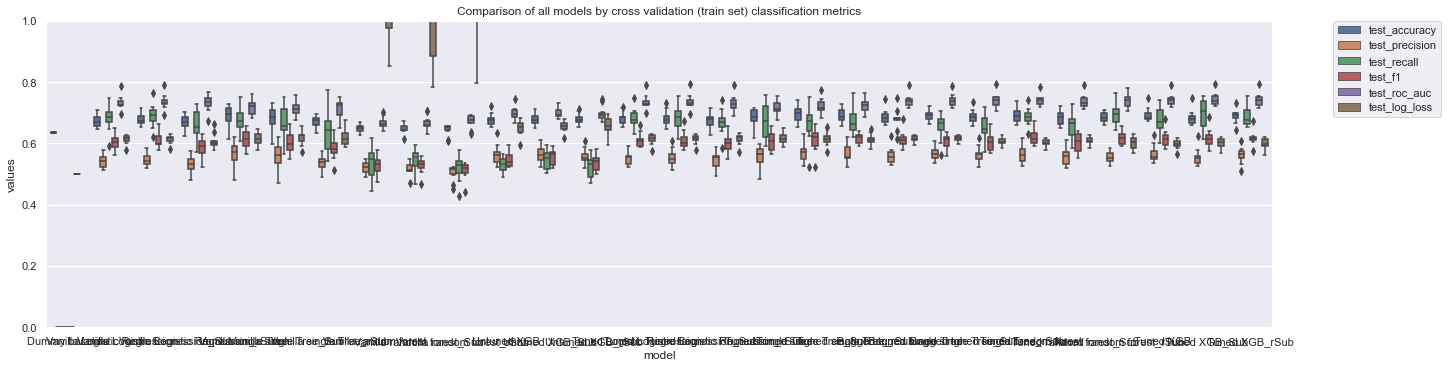

In [142]:
# Show results for all models
plt.figure(figsize=(20, 5), constrained_layout=True)
sns.boxplot(x="model", y="values", hue="metrics", data=cv_results_plots)#, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.title('Comparison of all models by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

## Classification - Cross validated scores of best models

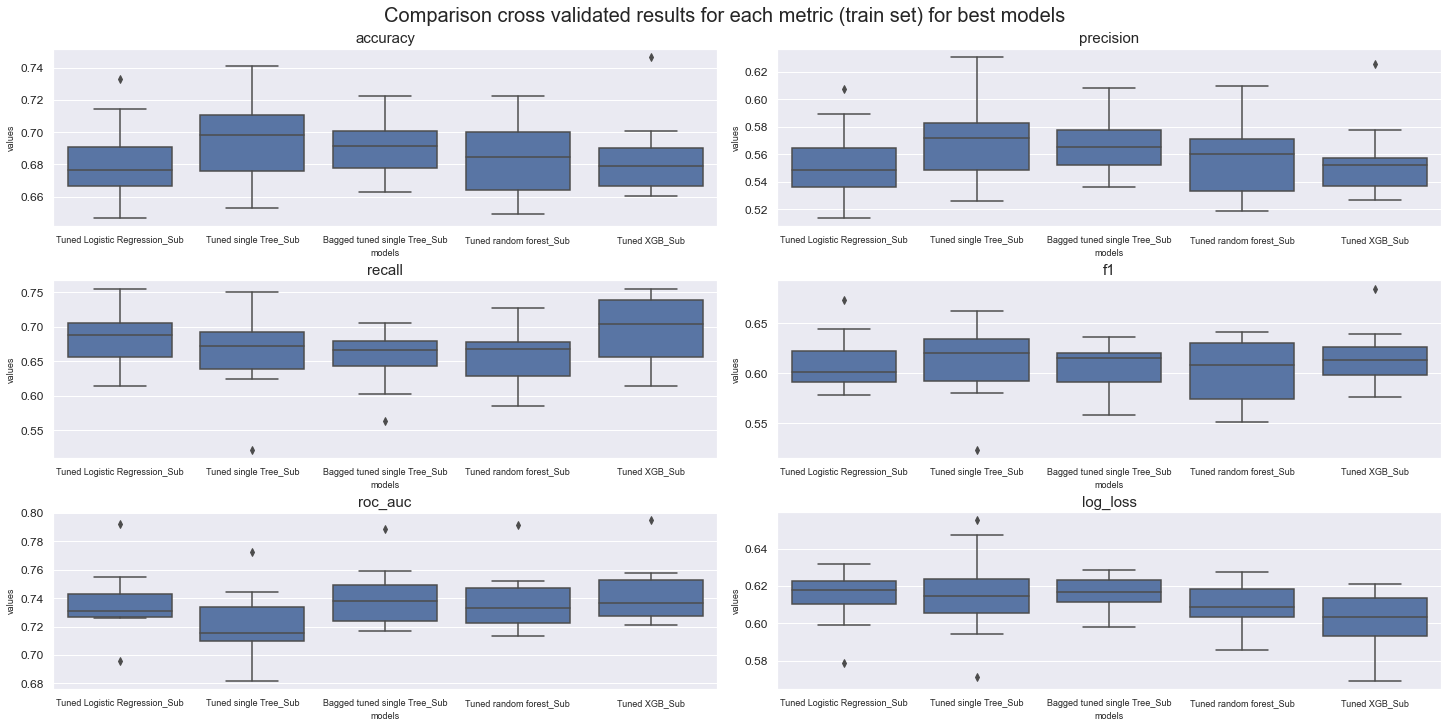

In [135]:
# best models
best_models = cv_results_plots[cv_results_plots["model"].isin(best_model_list)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for best models', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(best_models.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=best_models[best_models["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

In [134]:
# Select best models and compare test scores
# Filter df for best models
dict_best = {nk: dict_models[nk] for nk in best_model_list}

In [136]:
metrics_names = clf_scoring.copy()
metrics_names[-1]="log_loss"
test_metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss]
metrics_dict = dict(zip(metrics_names, test_metrics))

In [137]:
dict_test ={}
for me_name, metric in metrics_dict.items():
    test_scores = []
    for model in dict_best.values():
        if me_name=="log_loss":
            y_pred = model.predict_proba(X_test)
        else:
            y_pred = model.predict(X_test)
        test_scores.append(metric(y_test, y_pred))
    dict_test[me_name]=test_scores

In [138]:
test_scores_df = pd.DataFrame(dict_test, index=best_model_list)

## Classification - Test scores for best models 

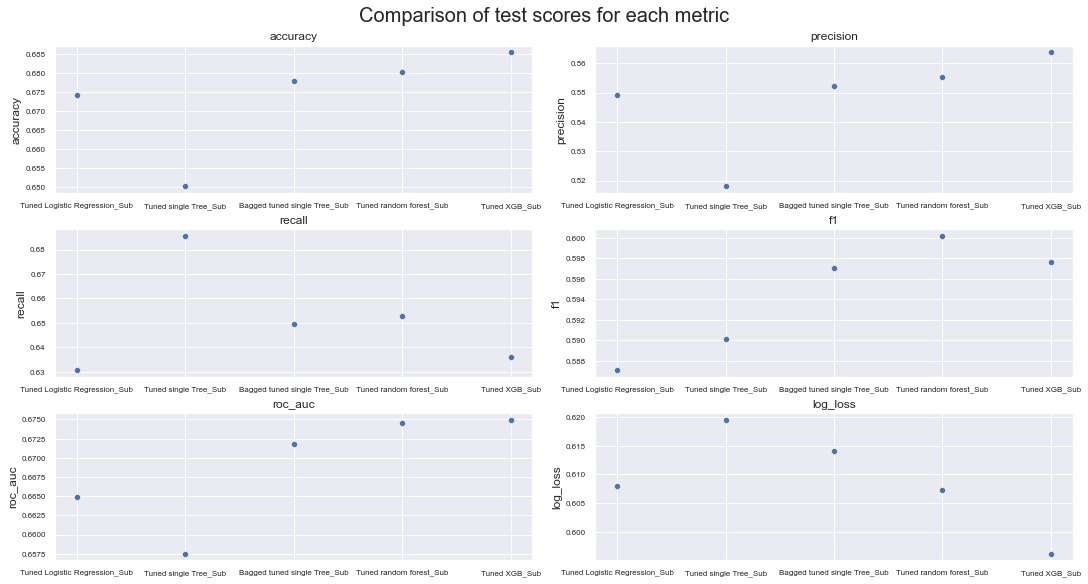

In [139]:
#
fig, ax = plt.subplots(3,2, figsize=(15,8), constrained_layout=True)
fig.suptitle('Comparison of test scores for each metric', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(test_scores_df.columns):
    chart = sns.scatterplot(x=test_scores_df.index, y=metric, data=test_scores_df, ax=ax[i])    
    ax[i].tick_params(labelsize=8)
    ax[i].set_title(metric, fontsize=12)

## Classification - Confusion matrix for best models

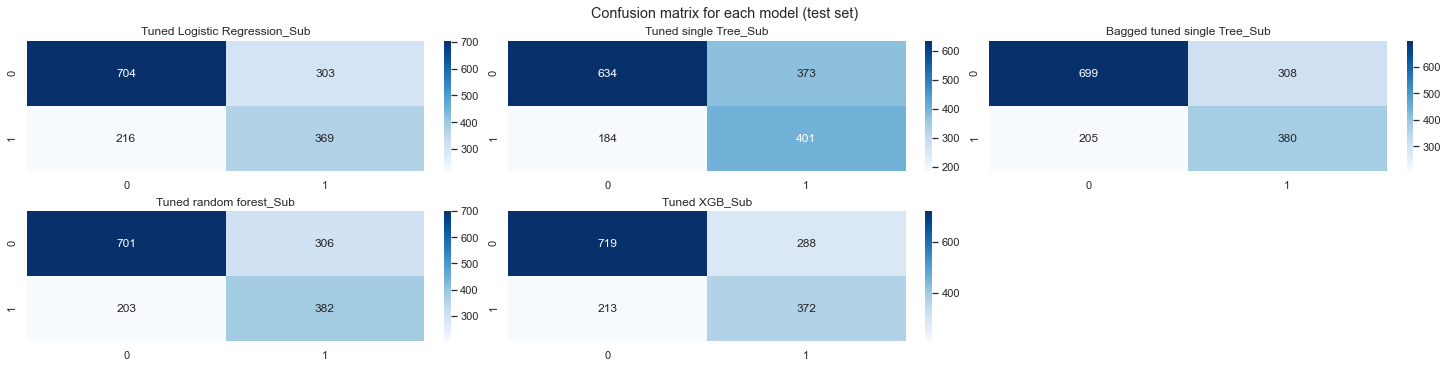

In [140]:
# confusion matrixes
fig, ax = plt.subplots(2,3, figsize=(20,5), constrained_layout=True)
fig.suptitle('Confusion matrix for each model (test set)')
ax = ax.ravel()
ax[-1].set_visible(False)
i=0

for name, model in dict_best.items():
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True, ax=ax[i], fmt='d', cmap='Blues')
    ax[i].set_title(name, fontsize=12)
    i+=1

## Classification - Interpretation of best model using SHAP

In [145]:
# Tuned XGB_sub as best estimator
best_estimator = dict_models["Tuned XGB_Sub"]
best_estimator

#apply the preprocessing to X_test
X_test_trans = pd.DataFrame(preproc_s.transform(X_test), columns=column_nam_sub)

#reverse scaling for better interpretability of diagrams
X_test_unscaled = X_test_trans.copy()

#numerical features
X_test_unscaled[preproc_s.transformers_[0][2]]=preproc_s.transformers_[0][1][1].inverse_transform(X_test_trans[preproc_s.transformers_[0][2]])

#ordinal features
X_test_unscaled[preproc_s.transformers_[1][2]]=preproc_s.transformers_[1][1][2].inverse_transform(X_test_trans[preproc_s.transformers_[1][2]])

### MDI feature importance

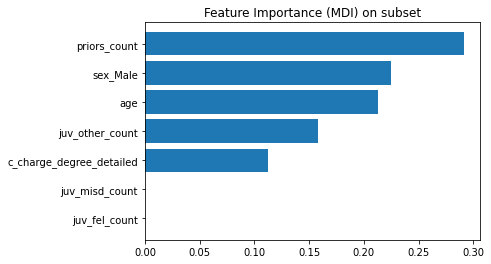

In [350]:
#Check feature importance of best model
feature_importance_s = grid_XGB_s.best_estimator_.named_steps["xgbclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance_s)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance_s[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train_sub_trans.columns)[sorted_idx])
plt.title("Feature Importance (MDI) on subset");


## Shap values

### Global interpretability


#### Variable Importance Plot

In [171]:
#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(best_estimator['xgbclassifier'])

#get Shap values from preprocessed data
shap_values = explainer.shap_values(X_test_trans)

In [154]:
#reset style
sns.reset_orig()

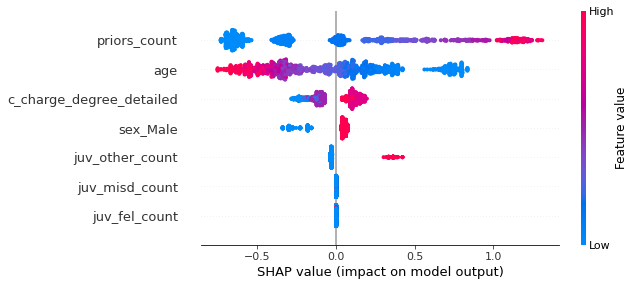

In [161]:
# Shap values
shap.summary_plot(shap_values, X_test_trans)

### SHAP Partial Dependence Plot

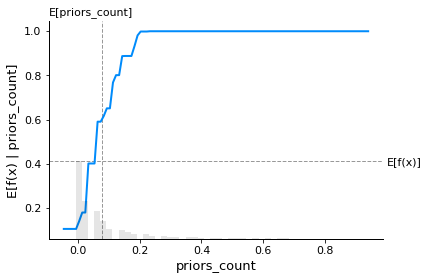

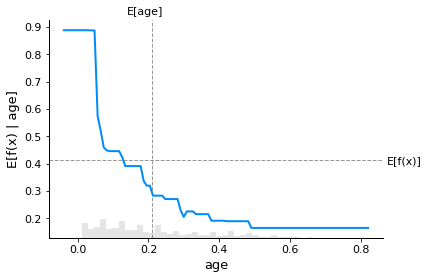

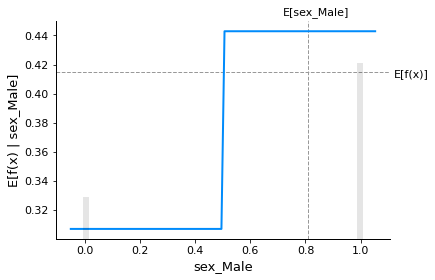

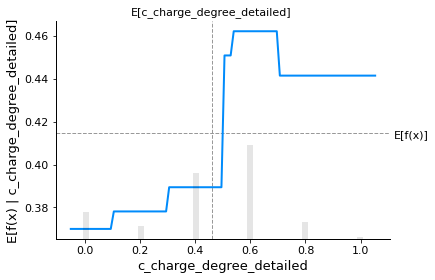

In [162]:
features_list = ["priors_count", "age", "sex_Male", "c_charge_degree_detailed"]
for i in features_list:
    shap.plots.partial_dependence(
    i, best_estimator['xgbclassifier'].predict, X_test_trans.values, ice=False,
    model_expected_value=True, feature_expected_value=True, feature_names=X_test_trans.columns
    )

#### SHAP Dependence Plot

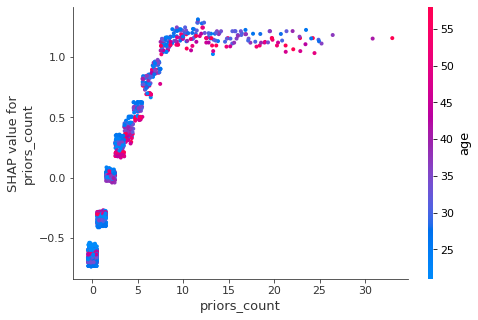

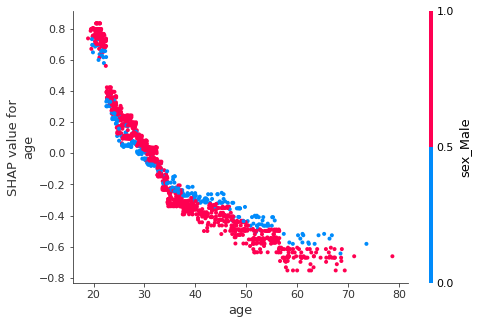

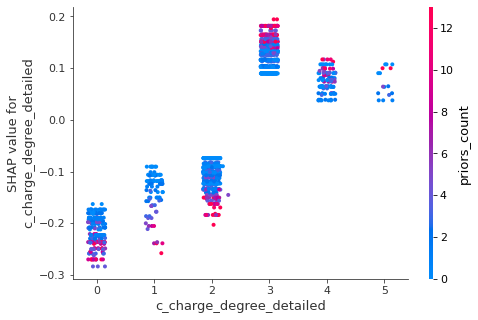

In [163]:
features_list = ["priors_count","age", "c_charge_degree_detailed"]

for i, feature in enumerate(features_list):
    shap.dependence_plot(feature, shap_values, X_test_unscaled, x_jitter=10)

## Local Interpretability

### Individual SHAP Value Plot

In [198]:
#load JS vis in the notebook
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[rand_row,:], features=X_test_unscaled.iloc[rand_row,:])

In [199]:
#Select random case from test data
np.random.seed(42)
rand_row = np.random.randint(0,X_test_unscaled.shape[0],1)
pd.concat([X_test_unscaled.iloc[rand_row,:],y_test[X_test_unscaled.iloc[rand_row,:].index]], axis=1)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
1126,25.0,0.0,0.0,0.0,0.0,2.0,1.0,0


### Check multiple samples (first 100 cases) at once

In [200]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], features=X_test_unscaled.iloc[:100,:])

Let's look for some special cases and compare them with the truth

In [201]:
ind= 39 # max out of 100 samples
display(X_test_unscaled.loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male
39,24.0,0.0,0.0,0.0,8.0,3.0,1.0


In [202]:
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
39,24.0,0.0,0.0,0.0,8.0,3.0,1.0,0


In [203]:
ind= 74 # minimum out of 100 samples
display(X_test_unscaled.loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male
74,55.0,0.0,0.0,0.0,0.0,0.0,1.0


In [204]:
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
74,55.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [205]:
ind= 34 # high priors, but low epected value
display(X_test_unscaled.loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male
34,69.0,0.0,0.0,0.0,22.0,1.0,1.0


In [206]:
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
34,69.0,0.0,0.0,0.0,22.0,1.0,1.0,0


In [207]:
ind= 79 # most severe crime
display(X_test_unscaled.loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_unscaled.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male
79,22.0,0.0,0.0,0.0,1.0,5.0,1.0


In [208]:
display(pd.concat([X_test_unscaled,y_test.reset_index(drop=True)], axis=1).loc[[ind]])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
79,22.0,0.0,0.0,0.0,1.0,5.0,1.0,1


# Regression

# Fairness discussion

In [209]:
#Select relevant columns
df_small = df[["sex","age_cat", "race", "score_text", "two_year_recid"]].copy()

# Combine Medium and High Risk score into one category
df_small["score_text"] = df_small.score_text.apply(lambda x: "Low" if x=="Low" else "Medium/High")

In [210]:
# Filter df for white and black
df_small_b = df_small[df_small["race"]=="African-American"]
df_small_w = df_small[df_small["race"]=="Caucasian"]

In [211]:
# Create separate .groupby (for plotting reasons)
df_plot_b = df_small_b[['score_text', 'two_year_recid']].groupby(['score_text', 'two_year_recid']).size().reset_index().pivot(columns='two_year_recid', index='score_text')
df_plot_w = df_small_w[['score_text', 'two_year_recid']].groupby(['score_text', 'two_year_recid']).size().reset_index().pivot(columns='two_year_recid', index='score_text')


In [212]:
# Create list for percentage labels within barchart (order has to be this way, due to plotting reasons)

#Black defendants
label_b_recid = [np.round(e/df_plot_b.iloc[0,:].sum()*100,1) for e in df_plot_b.iloc[0,:]]
label_b_worecid = [np.round(e/df_plot_b.iloc[1,:].sum()*100,1) for e in df_plot_b.iloc[1,:]]

labels_black = [[label_b_recid[0],label_b_worecid[0]], [label_b_recid[1],label_b_worecid[1]]]

#White defendants
label_w_recid = [np.round(e/df_plot_w.iloc[0,:].sum()*100,1) for e in df_plot_w.iloc[0,:]]
label_w_worecid = [np.round(e/df_plot_w.iloc[1,:].sum()*100,1) for e in df_plot_w.iloc[1,:]]

labels_white = [[label_w_recid[0],label_w_worecid[0]], [label_w_recid[1],label_w_worecid[1]]]

#Combined list for barplot
lables_barplot = [labels_black, labels_white]

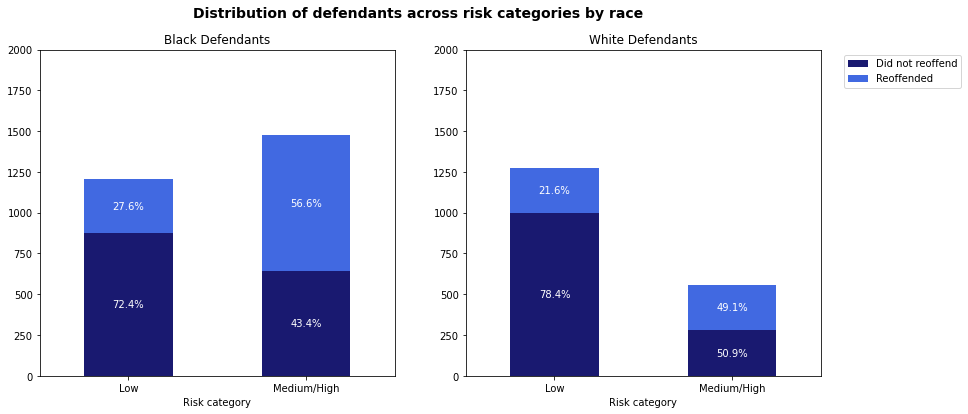

In [213]:
fig, axes = plt.subplots(1,2, figsize=(14,6))#, gridspec_kw={'width_ratios': [3,3,1]})
fig.suptitle("Distribution of defendants across risk categories by race", fontsize=14, fontweight="bold")

#Black defendants
df_plot_b.plot(kind='bar', stacked=True, ax=axes[0], color=["midnightblue", "royalblue"])
            
axes[0].set_title("Black Defendants")
axes[0].get_legend().remove()
#axes[0].legend(labels=["Did not reoffend","Reoffended"])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

#White defendants
df_plot_w.plot(kind='bar', stacked=True, ax=axes[1], color=["midnightblue", "royalblue"])
            
axes[1].set_title("White Defendants")
axes[1].get_legend().remove()
axes[1].legend(labels=["Did not reoffend","Reoffended"],bbox_to_anchor=(1.05, 1.0), loc='upper left')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

#Set labels within bar plot 
for j in range(2):
    labels = lables_barplot[j]
    for i, container in enumerate(axes[j].containers):
        axes[j].bar_label(container, labels=['%.1f%%' %e for e in labels[i]], label_type='center', color='w')

plt.setp(axes, ylim=(0,2000), xlabel="Risk category");
#plt.legend(labels=["Did not reoffend","Reoffended"])
    

In [1]:
# Save the notebook and Run this cell to create slideshow (.html file will be generated in folder of notebook)
!jupyter nbconvert Final_presentation.ipynb --to slides --post serve \
--no-prompt \
--TagRemovePreprocessor.remove_input_tags=remove_input \
--TagRemovePreprocessor.remove_all_outputs_tags=remove_output

[NbConvertApp] Converting notebook Final_presentation.ipynb to slides
[NbConvertApp] Writing 2014857 bytes to Final_presentation.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Final_presentation.slides.html
Use Control-C to stop this server
^C

Interrupted
